# Geospatial analysis

## Load libraries

In [1]:
import pandas as pd
import geopandas as gpd
import folium
from branca.element import Figure
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import osmnx as ox
from shapely.ops import transform
import pyproj
from shapely.geometry import Point, LineString, Polygon
import pyrosm
import matplotlib.pyplot as plt
import contextily as cx

## 6. Find the location of 3 AirBnB hosts closest to one of the city's museums (on walking distance)

### Street network analysis: find the shortest walking paths between MAS museum and the 3 closest Airbnb

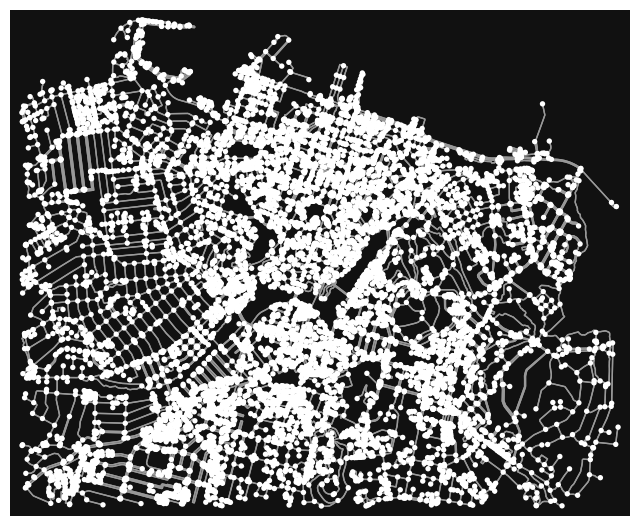

In [104]:
# Retrieve and plot all the walking streets of the city
G = ox.graph_from_address("Auckland, New Zealand", network_type='walk', dist=3000)
# Add speed and travel time
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
fig, ax = ox.plot_graph(G)

In [105]:
# Connect the supply points to the graph
stations = gpd.read_file("data/transport/public_transport/sample_stations.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations["points_to_graph"] = stations.geometry.apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))
stations = gpd.GeoDataFrame(stations, geometry = stations.geometry)
stations

,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTYPE,STOPLAT,STOPLON,PARENTSTATION,MODE,lon,lat,u,v,dist,geometry,points_to_graph
0,11,277,277,Grafton Train Station,None,Stop,-36.865612,174.769840,None,Train,174.769840,-36.865612,2765835305,2765835293,0,POINT (174.76984 -36.86561),3591613174
1,19,133,133,Britomart Train Station,None,Stop,-36.844291,174.768480,None,Train,174.768480,-36.844291,8808664536,8808664534,0,POINT (174.76848 -36.84429),8808664536
2,36,140,140,Parnell Train Station,None,Stop,-36.854728,174.777399,None,Train,174.777399,-36.854728,8628536361,3926522434,0,POINT (174.77740 -36.85473),8628536361
3,40,135,135,The Strand Train Station,None,Stop,-36.848536,174.779341,None,Train,174.779341,-36.848536,2981998375,7994688057,0,POINT (174.77934 -36.84854),9548340833


In [106]:
ox.distance.nearest_nodes(G, stations.iloc[0].geometry.x, stations.iloc[0].geometry.y)

3591613174

In [131]:
# Connect the demand points to the graph
grid = gpd.read_file("data/geographic/grids/sample_grid_all.gpkg")
grid = gpd.GeoDataFrame(grid, geometry = grid.geometry)
grid = grid.to_crs(stations.crs)
grid['lon'] = grid['geometry'].x
grid['lat'] = grid['geometry'].y
grid["points_to_graph"] = grid.geometry.apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))                                                                         

grid.head(3)

,geometry,lon,lat,points_to_graph
0,POINT (174.76739 -36.85513),174.767391,-36.855133,1663337824
1,POINT (174.76867 -36.85514),174.768671,-36.855141,1210037527
2,POINT (174.76995 -36.85515),174.769951,-36.855149,7210661940


In [146]:
grid["paths_to_mas"] = grid.points_to_graph.apply(lambda x: ox.shortest_path(G, grid['points_to_graph'].iloc[0], stations['points_to_graph'].iloc[0], weight='travel_time'))


,geometry,lon,lat,points_to_graph,paths_to_mas
0,POINT (174.76739 -36.85513),174.767391,-36.855133,1663337824,"[1663337824, 1663337816, 7871790895, 613651101..."
1,POINT (174.76867 -36.85514),174.768671,-36.855141,1210037527,"[1663337824, 1663337816, 7871790895, 613651101..."
2,POINT (174.76995 -36.85515),174.769951,-36.855149,7210661940,"[1663337824, 1663337816, 7871790895, 613651101..."
3,POINT (174.77123 -36.85516),174.771231,-36.855157,25770127,"[1663337824, 1663337816, 7871790895, 613651101..."
4,POINT (174.77251 -36.85516),174.772511,-36.855165,98233467,"[1663337824, 1663337816, 7871790895, 613651101..."
...,...,...,...,...,...
124,POINT (174.77262 -36.84385),174.772618,-36.843850,4331930913,"[1663337824, 1663337816, 7871790895, 613651101..."
125,POINT (174.77390 -36.84386),174.773898,-36.843858,9012830692,"[1663337824, 1663337816, 7871790895, 613651101..."
126,POINT (174.77518 -36.84387),174.775178,-36.843866,4331934991,"[1663337824, 1663337816, 7871790895, 613651101..."
127,POINT (174.77646 -36.84387),174.776458,-36.843874,1017168928,"[1663337824, 1663337816, 7871790895, 613651101..."


In [142]:
# retrieve path by node
paths_to_mas = ox.shortest_path(G, grid['points_to_graph'].iloc[0], stations['points_to_graph'].iloc[0], weight='travel_time')


In [134]:
# Retrieve paths' lenth in meters
paths_to_mas_m = sum(ox.utils_graph.get_route_edge_attributes(G, paths_to_mas, 'length'))
paths_to_mas_m

#airbnb_and_neigh_subset["paths_to_mas_m"] = airbnb_and_neigh_subset.paths_to_mas.apply(lambda x: sum(ox.utils_graph.get_route_edge_attributes(G, x, 'length')))

2010.6980000000003

In [135]:
#here continue

In [126]:
# Sort in ascending order

airbnb_and_neigh_subset = airbnb_and_neigh_subset.sort_values(by='paths_to_mas_m')

NameError: name 'airbnb_and_neigh_subset' is not defined

In [127]:
airbnb_and_neigh_subset.head(3)

NameError: name 'airbnb_and_neigh_subset' is not defined

Now, what about the travel time to reach these 3 Airbnb?

In [136]:
import datetime
travel_time1 = sum(ox.utils_graph.get_route_edge_attributes(G, paths_to_mas, 'length'))
print("Travel time on foot from MAS to the first Airbnb:", str(datetime.timedelta(seconds=travel_time1)))

Travel time on foot from MAS to the first Airbnb: 0:33:30.698000


### Visualize this analyses on a map

In [137]:
stations

,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTYPE,STOPLAT,STOPLON,PARENTSTATION,MODE,lon,lat,u,v,dist,geometry,points_to_graph
0,11,277,277,Grafton Train Station,None,Stop,-36.865612,174.769840,None,Train,174.769840,-36.865612,2765835305,2765835293,0,POINT (174.76984 -36.86561),3591613174
1,19,133,133,Britomart Train Station,None,Stop,-36.844291,174.768480,None,Train,174.768480,-36.844291,8808664536,8808664534,0,POINT (174.76848 -36.84429),8808664536
2,36,140,140,Parnell Train Station,None,Stop,-36.854728,174.777399,None,Train,174.777399,-36.854728,8628536361,3926522434,0,POINT (174.77740 -36.85473),8628536361
3,40,135,135,The Strand Train Station,None,Stop,-36.848536,174.779341,None,Train,174.779341,-36.848536,2981998375,7994688057,0,POINT (174.77934 -36.84854),9548340833


In [138]:
# Create basemap
fig5 = Figure(width = 800, height = 800)
station = stations.iloc[0]
m5 = folium.Map(location = [station.lon,station.lat], tiles = 'openstreetmap', zoom_start = 16)

# Add grid

folium.GeoJson(grid, tooltip="MAS museum").add_to(m5)

# Add station
mas_museum = (station.lat, station.lon)
point_mas = Point(mas_museum[0], mas_museum[1])

folium.GeoJson(point_mas, tooltip="MAS museum").add_to(m5)

# Add Airbnb paths
ox.folium.plot_route_folium(G, paths_to_mas, route_map=m5, tiles='OpenStreetMap', route_color="blue")

## 7. Of the three hosts, identify which one has the greatest number of services (supermarkets, pharmacies, restaurants) in an area of 300m

### Retrieve all supermarkets, pharmacies and restaurants (fast-food included) of Antwerp from Openstreetmap

Same procedure as the one done before with the tourist activities.

In [68]:
# Geometry of Antwerp

antwerp_geom = antwerp.geometry.values[0]

In [69]:
osm = pyrosm.OSM("Antwerp_bbox.osm.pbf", bounding_box = antwerp_geom)

In [70]:
custom_filter = {"amenity": ["pharmacy", "restaurant", "fast_food"], "shop": ["supermarket"]}
antwerp_services = osm.get_pois(custom_filter = custom_filter)

In [71]:
# Combine tags from "amenity" and "shop"

antwerp_services["service_type"] = antwerp_services["amenity"]
antwerp_services["service_type"] = antwerp_services["service_type"].fillna(antwerp_services["shop"])

In [72]:
antwerp_services.head(3)

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
0,NaN,"{""delivery"":""no"",""outdoor_seating"":""yes"",""smok...",7,NaN,27268548,NaN,1584093404,Savanne restaurant,restaurant,"POLYGON ((4.42467 51.21651, 4.42478 51.21669, ...",...,None,None,None,yes,None,None,None,None,None,restaurant
1,NaN,"{""cuisine"":""regional""}",3,NaN,40196194,NaN,1586160497,Makro,restaurant,"POLYGON ((4.49593 51.22078, 4.49602 51.22056, ...",...,None,None,None,yes,None,None,None,None,None,restaurant
2,NaN,"{""OnroerendErfgoed:criteria"":""M"",""cuisine"":""re...",5,NaN,42648810,NaN,1502954049,Het Pomphuis,restaurant,"POLYGON ((4.40827 51.24179, 4.40819 51.24161, ...",...,None,http://www.hetpomphuis.be/,None,yes,None,None,None,None,None,restaurant


### Change crs (from WSG 84 to UTM31N) in order to extract the buffers around the three Airbnb

In [86]:
# 3 Airbnb closest to MAS

airbnb1 = airbnb_and_neigh_subset[airbnb_and_neigh_subset.listing_url == "https://www.airbnb.com/rooms/8473696"]
airbnb2 = airbnb_and_neigh_subset[airbnb_and_neigh_subset.listing_url == "https://www.airbnb.com/rooms/4592434"]
airbnb3 = airbnb_and_neigh_subset[airbnb_and_neigh_subset.listing_url == "https://www.airbnb.com/rooms/22703318"]

In [87]:
# Change crs to be able to compute the buffer in meters

wgs84 = pyproj.CRS('EPSG:4326')
utm31n = pyproj.CRS('EPSG:32631')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm31n, always_xy=False).transform

airbnb1_utm31n = transform(projection_transform, Point(airbnb1.geometry.y, airbnb1.geometry.x))
airbnb2_utm31n = transform(projection_transform, Point(airbnb2.geometry.y, airbnb2.geometry.x))
airbnb3_utm31n = transform(projection_transform, Point(airbnb3.geometry.y, airbnb3.geometry.x))

In [88]:
# Convert the dataframe with the services as well

antwerp_services_utm31n = antwerp_services.to_crs('epsg:32631')

In [89]:
# Create basemap
fig6 = Figure(width = 800, height = 800)
m6 = folium.Map(location = [mas_museum[0],mas_museum[1]], tiles = 'openstreetmap', zoom_start = 11)

# Add Airbnb
folium.GeoJson(airbnb1.geometry, tooltip="Airbnb 1").add_to(m6)
folium.GeoJson(airbnb2.geometry, tooltip="Airbnb 2").add_to(m6)
folium.GeoJson(airbnb3.geometry, tooltip="Airbnb 3").add_to(m6)

# Add geometry of the city of Antwerp
folium.GeoJson(
    antwerp,
    style_function=lambda feature: {
        'fillColor': 'red',
        'color': 'black',
        'weight': 0.5
    }
    ).add_to(m6)

# Plot all the services retrieved by osm
folium.GeoJson(
    antwerp_services
    ).add_to(m6)

fig6.add_child(m6)
m6
# m6.save(outfile = 'services_airbnb.html')

Note: since within a 300 m buffer there results to be only one service, I decided to extend it to 800 m. 

In [90]:
services_around_airbnb1 = antwerp_services_utm31n[antwerp_services_utm31n.geometry.within(airbnb1_utm31n.buffer(800))]
services_around_airbnb1

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
24,NaN,"{""cuisine"":""regional""}",6,NaN,116180040,NaN,1498668490,'t lastig portret,restaurant,"POLYGON ((598211.024 5675544.191, 598212.675 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
50,NaN,"{""cuisine"":""international""}",2,NaN,239552389,NaN,1503071227,Windkracht 13,restaurant,"POLYGON ((597375.460 5676483.794, 597383.479 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
76,NaN,"{""alt_name"":""U eat & sleep"",""tourism"":""hotel""}",4,NaN,483462288,NaN,1546453252,U,restaurant,"POLYGON ((598099.898 5676321.657, 598105.864 5...",...,None,http://www.u-eatsleep.be/,None,yes,None,None,None,None,None,restaurant
78,NaN,"{""diet:vegan"":""only"",""diet:vegetarian"":""yes"",""...",3,NaN,496711213,NaN,1566888921,Sweet Vegan,fast_food,"POLYGON ((597745.795 5675463.624, 597747.293 5...",...,None,https://www.sweetvegan.be,None,yes,None,None,None,None,None,fast_food


In [91]:
services_around_airbnb2 = antwerp_services_utm31n[antwerp_services_utm31n.geometry.within(airbnb2_utm31n.buffer(800))]
services_around_airbnb2

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
24,NaN,"{""cuisine"":""regional""}",6,NaN,116180040,NaN,1498668490,'t lastig portret,restaurant,"POLYGON ((598211.024 5675544.191, 598212.675 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
76,NaN,"{""alt_name"":""U eat & sleep"",""tourism"":""hotel""}",4,NaN,483462288,NaN,1546453252,U,restaurant,"POLYGON ((598099.898 5676321.657, 598105.864 5...",...,None,http://www.u-eatsleep.be/,None,yes,None,None,None,None,None,restaurant


In [92]:
services_around_airbnb3 = antwerp_services_utm31n[antwerp_services_utm31n.geometry.within(airbnb3_utm31n.buffer(800))]
services_around_airbnb3

,changeset,tags,version,lat,id,lon,timestamp,name,amenity,geometry,...,url,website,bar,building,building:levels,source,start_date,organic,shop,service_type
24,NaN,"{""cuisine"":""regional""}",6,NaN,116180040,NaN,1498668490,'t lastig portret,restaurant,"POLYGON ((598211.024 5675544.191, 598212.675 5...",...,None,None,None,yes,None,None,None,None,None,restaurant
76,NaN,"{""alt_name"":""U eat & sleep"",""tourism"":""hotel""}",4,NaN,483462288,NaN,1546453252,U,restaurant,"POLYGON ((598099.898 5676321.657, 598105.864 5...",...,None,http://www.u-eatsleep.be/,None,yes,None,None,None,None,None,restaurant


The Airbnb with the highest number of services results to be the first one. It has 3 restaurants and 1 fast food within a 800 m buffer. However, the number of retrieved services appears to be quite low (i.e. no supermarkets or pharmacies). In fact, by looking at Google Maps, it appears that osm has not retrieved all the services of the area.

## 8. Analyze and test spatial autocorrelation of price

In order to do so, I am going to use the "neigh_price" dataframe created at point 4. However, I am going to add also the neighbourhoods without Airbnb and give them a mean price of 0. I think that this information is important when analyzing the spatial autocorrelation of price. As we saw in the previous maps, the neighbourhoods without Airbnb are the less central, with less tourist activities and probably the cheapest ones in terms of general services.

In [99]:
# Add all neighbourhoods

all_neigh = pd.merge(antwerp_neigh, neigh_price[["neigh_code", "price_euros"]], how="left", on="neigh_code").fillna(0)

In [100]:
# Save in .shp

all_neigh.to_file("neigh_price.shp")

In [101]:
# Load the extension to include R code

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [102]:
%%R

library(rgdal)
library(spdep)

In [103]:
%%R

# Load .shp file
neigh_price <- readOGR("neigh_price","neigh_price")
summary(neigh_price)

OGR data source with driver: ESRI Shapefile 
Source: "", layer: "neigh_price"
with 63 features
It has 7 fields
Integer64 fields read as strings:  ID 


From cffi callback <function _consolewrite_ex at 0x000001EE1B5BD160>:
Traceback (most recent call last):
  File "C:\Users\Marta\anaconda3\envs\geo_env\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\Marta\anaconda3\envs\geo_env\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 38: invalid continuation byte


Object of class SpatialPolygonsDataFrame
Coordinates:
        min       max
x  4.243408  4.497903
y 51.143323 51.377664
Is projected: FALSE 
proj4string : [+proj=longlat +datum=WGS84 +no_defs]
Data attributes:
      ID             neigh_name         neigh_code          shape_Leng   
 Length:63          Length:63          Length:63          Min.   : 1482  
 Class :character   Class :character   Class :character   1st Qu.: 4683  
 Mode  :character   Mode  :character   Mode  :character   Median : 6143  
                                                          Mean   : 7537  
                                                          3rd Qu.: 8109  
                                                          Max.   :34648  
   shape_Area           city             price_euro    
 Min.   :  133651   Length:63          Min.   :  0.00  
 1st Qu.:  907838   Class :character   1st Qu.: 43.46  
 Median : 1279334   Mode  :character   Median : 62.44  
 Mean   : 2966304                      Mean   : 

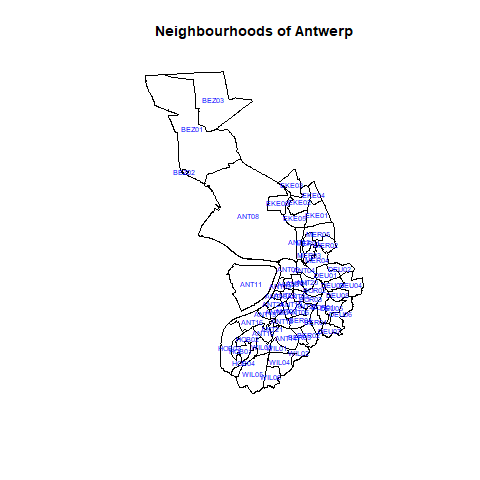

In [104]:
%%R

# Visualize the geometries of the neighbourhoods of the city.
plot(neigh_price)
text(coordinates(neigh_price), labels=neigh_price$neigh_code, cex=0.6, col="blue")
title(main = "Neighbourhoods of Antwerp")

### Build the spatial weights matrix

The first step to test any spatial correlation is to build a spatial weights matrix. It is a good practice to build different ones, according to different definitions of neighbourhood relationships amongst the spatial units.

Let's start with the **k-nearest neighbours** criterion and in particular with k=1.

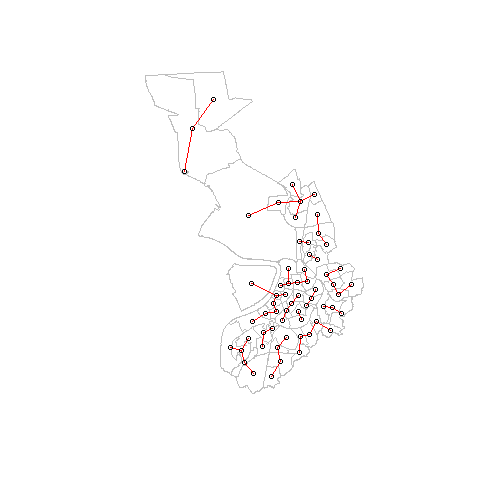

In [105]:
%%R

# Compute centroids as representative points of the neighbourhoods of Antwerp
centroids <- coordinates(neigh_price)

# knn algorithm
knn1 <- knn2nb(knearneigh(centroids, k=1, longlat = T))

# Visualize them
plot(neigh_price, border="grey")
plot(knn1, centroids, col="red", add=TRUE)

In [106]:
%%R

# Build a row standardize weights matrix 

knn1.listw <- nb2listw(knn1, style = "W")

Build the spatial weights matrix according to the **critical cut-off neighbourhood** criterion and choose different cut-off levels.

In [107]:
%%R

# Compute the min distance since we want all neighbourhoods to have at least one neighbour

min.dist <- max(unlist(nbdists(knn1, centroids, longlat=T)))
min.dist

[1] 3.56063


In [108]:
%%R

# Different cut-off levels

dnb1 <- dnearneigh(centroids, 0, 4, longlat = TRUE)
dnb2 <- dnearneigh(centroids, 0, 8, longlat = TRUE)
dnb3 <- dnearneigh(centroids, 0, 12, longlat = TRUE)

# Build row standardize matrices

dnb1.listw <- nb2listw(dnb1, style = "W")
dnb2.listw <- nb2listw(dnb2, style = "W")
dnb3.listw <- nb2listw(dnb3, style = "W")

**Free-form spatial weight matrix**: create weights as inverse functions of the distance among centroids.

In [109]:
%%R

distM <- as.matrix(dist(centroids)) # euclidean distance
W1 <- 1/(1+(distM))
diag(W1) <- 0                       # 0 values to the diagonal
W1 <- W1/rowSums(W1)                # row standardize it
listW1 <- mat2listw(W1)             # convert into a listw object for computational reasons

### Global spatial autocorrelation: Moran's I test

Visually inspect the spatial quantile distribution of the average Airbnb price.

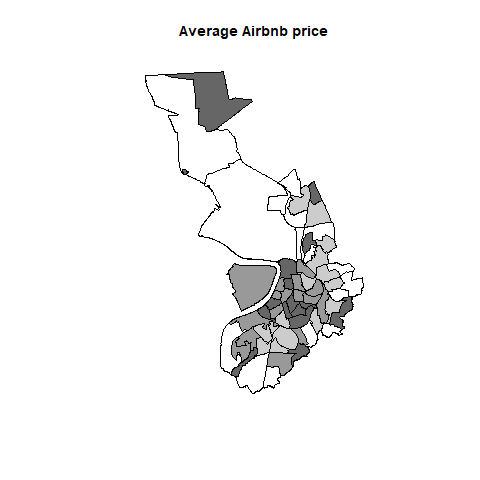

In [110]:
%%R

brks <- round(quantile(neigh_price$price_euro), digits=3)
colours <- grey((length(brks):2)/length(brks))
plot(neigh_price, col=colours[findInterval(neigh_price$price_euro, brks, all.inside=TRUE)])
title(main = "Average Airbnb price")

From the plot, there seems to be a sort of spatial dependence in the central neighbourhoods (the neighbourhoods which belong to the Antwerpen district). However, it is important to check if it is statistically significant by computing the Moran's I index.
Let's compute it for each spatial weights matrix built before, starting by assuming a **normal distribution** of our data.

In [111]:
%%R

print(moran.test(neigh_price$price_euro, knn1.listw, randomisation = FALSE)) # 1 knn
print(moran.test(neigh_price$price_euro, dnb1.listw, randomisation = FALSE)) # 4 km cut-off
print(moran.test(neigh_price$price_euro, dnb2.listw, randomisation = FALSE)) # 8 km cut-off
print(moran.test(neigh_price$price_euro, dnb3.listw, randomisation = FALSE)) # 12 km cut-off
print(moran.test(neigh_price$price_euro, listW1, randomisation = FALSE))     # free form


	Moran I test under normality

data:  neigh_price$price_euro  
weights: knn1.listw    

Moran I statistic standard deviate = -0.69761, p-value = 0.7573
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.12241704       -0.01612903        0.02321336 


	Moran I test under normality

data:  neigh_price$price_euro  
weights: dnb1.listw    

Moran I statistic standard deviate = -2.4272, p-value = 0.9924
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.133776555      -0.016129032       0.002349442 


	Moran I test under normality

data:  neigh_price$price_euro  
weights: dnb2.listw    

Moran I statistic standard deviate = -2.8869, p-value = 0.9981
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -0.0967321895     -0.0161290323      0.0007795212 


	Moran I test under normality

data:  neigh_price$price_eur

All p-values result to be really high. This tells us that we cannot reject the null hp of no spatial autocorrelation of price.


Test, according to the **randomization assumption**.

In [112]:
%%R

print(moran.test(neigh_price$price_euro, knn1.listw, randomisation = TRUE)) # 1 knn
print(moran.test(neigh_price$price_euro, dnb1.listw, randomisation = TRUE)) # 4 km cut-off
print(moran.test(neigh_price$price_euro, dnb2.listw, randomisation = TRUE)) # 8 km cut-off
print(moran.test(neigh_price$price_euro, dnb3.listw, randomisation = TRUE)) # 12 km cut-off
print(moran.test(neigh_price$price_euro, listW1, randomisation = TRUE))     # free form


	Moran I test under randomisation

data:  neigh_price$price_euro  
weights: knn1.listw    

Moran I statistic standard deviate = -0.7102, p-value = 0.7612
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.12241704       -0.01612903        0.02239810 


	Moran I test under randomisation

data:  neigh_price$price_euro  
weights: dnb1.listw    

Moran I statistic standard deviate = -2.4709, p-value = 0.9933
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.13377655       -0.01612903        0.00226696 


	Moran I test under randomisation

data:  neigh_price$price_euro  
weights: dnb2.listw    

Moran I statistic standard deviate = -2.9389, p-value = 0.9984
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -0.0967321895     -0.0161290323      0.0007521995 


	Moran I test under randomisation

data:  neigh_

These results are in line with the previous ones: really high p-values meaning that we cannot reject the null hp of no spatial autocorrelation of price.


Test according to the **bootstrap approach**.

In [113]:
%%R

print(moran.mc(neigh_price$price_euro, knn1.listw, nsim=999)) # 1 knn
print(moran.mc(neigh_price$price_euro, dnb1.listw, nsim=999)) # 4 km cut-off
print(moran.mc(neigh_price$price_euro, dnb2.listw, nsim=999)) # 8 km cut-off
print(moran.mc(neigh_price$price_euro, dnb3.listw, nsim=999)) # 12 km cut-off
print(moran.mc(neigh_price$price_euro, listW1, nsim=999))     # free form


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: knn1.listw  
number of simulations + 1: 1000 

statistic = -0.12242, observed rank = 245, p-value = 0.755
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: dnb1.listw  
number of simulations + 1: 1000 

statistic = -0.13378, observed rank = 14, p-value = 0.986
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: dnb2.listw  
number of simulations + 1: 1000 

statistic = -0.096732, observed rank = 8, p-value = 0.992
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: dnb3.listw  
number of simulations + 1: 1000 

statistic = -0.060355, observed rank = 1, p-value = 0.999
alternative hypothesis: greater


	Monte-Carlo simulation of Moran I

data:  neigh_price$price_euro 
weights: listW1  
number of simulations + 1: 1000 

statistic = -0.0164

Once again, the high p-values do not allow us to reject the null hp of no spatial autocorrelation of price.   

We can conclude stating that we have no statistical evidence of global spatial autocorrelation of price in our data.

### Local spatial autocorrelation: Moran scatterplot

Let's check if there are relevant local spatial clusters by plotting the Moran scatterplots with respect to different specifications of the spatial weights matrix.

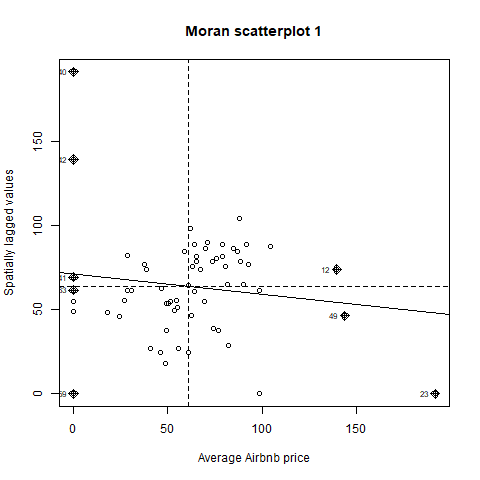

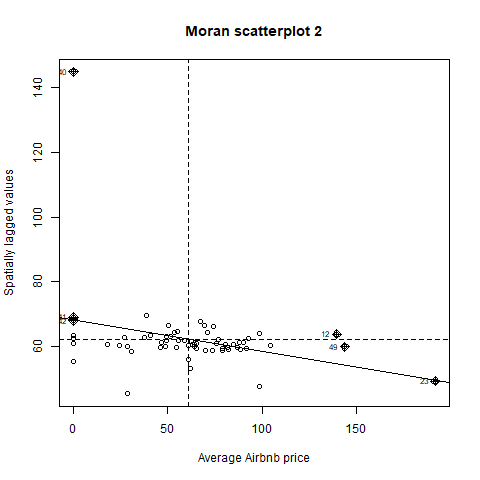

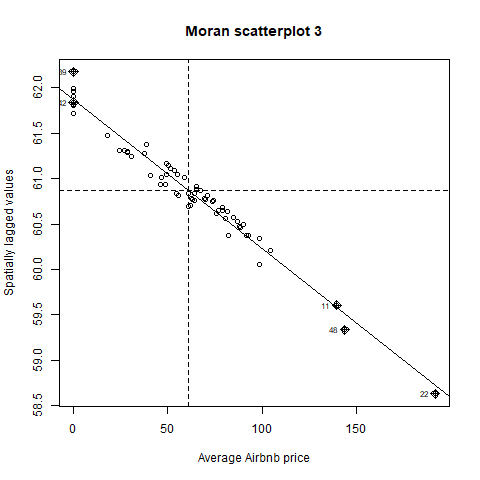

In [114]:
%%R

mplot1 <- moran.plot(neigh_price$price_euro, listw=knn1.listw, main="Moran scatterplot 1", xlab="Average Airbnb price", ylab="Spatially lagged values", return_df=F)
mplot2 <- moran.plot(neigh_price$price_euro, listw=dnb2.listw, main="Moran scatterplot 2", xlab="Average Airbnb price", ylab="Spatially lagged values", return_df=F)
mplot3 <- moran.plot(neigh_price$price_euro, listw=listW1, main="Moran scatterplot 3", xlab="Average Airbnb price", ylab="Spatially lagged values", return_df=F)

The first two plots show a really slight pattern of negative spatial autocorrelation, which becomes stronger in the third plot. This means that units close in space tend to have dissimilar price values.

In [115]:
%%R

# The summary() function isolates the most influential units with some measures of influence
summary(mplot1)
# summary(mplot2)
# summary(mplot3)

Potentially influential observations of
	 lm(formula = wx ~ x) :

   dfb.1_  dfb.x   dffit   cov.r   cook.d hat    
12 -0.13    0.20    0.22    1.12_*  0.02   0.09  
23  0.70   -0.96   -1.00_*  1.21_*  0.48   0.23_*
40  1.22_* -1.05_*  1.22_*  0.59_*  0.55   0.06  
41 -0.02    0.02   -0.02    1.10_*  0.00   0.06  
42  0.62   -0.53    0.62_*  0.92    0.18   0.06  
49  0.05   -0.08   -0.09    1.15_*  0.00   0.10_*
59 -0.65    0.56   -0.65_*  0.90    0.19   0.06  
63 -0.08    0.07   -0.08    1.10_*  0.00   0.06  


### Local spatial autocorrelation: local Moran's I index

The Moran scatterplot gives us an intuitive visual representation of local patterns of spatial autocorrelation, but we need to compute the local Moran's I index to understand if it is statistically significant.

In [116]:
%%R

# Again use different specifications of the spatial weights matrix

lmI1 <- localmoran(neigh_price$price_euro, knn1.listw)
print(head(lmI1))
lmI2 <- localmoran(neigh_price$price_euro, dnb2.listw)
print(head(lmI2))
lmI3 <- localmoran(neigh_price$price_euro, listW1)
print(head(lmI3))

             Ii        E.Ii    Var.Ii       Z.Ii Pr(z > 0)
1  0.0724045985 -0.01612903 0.9357581 0.09152221 0.4635388
2  0.0649172968 -0.01612903 0.9357581 0.08378216 0.4666148
3  0.1791897473 -0.01612903 0.9357581 0.20191204 0.4199927
4 -0.0003694133 -0.01612903 0.9357581 0.01629161 0.4935009
5  0.6738810154 -0.01612903 0.9357581 0.71330230 0.2378294
6  0.0226224053 -0.01612903 0.9357581 0.04005955 0.4840228
             Ii        E.Ii      Var.Ii        Z.Ii Pr(z > 0)
1 -0.0007960628 -0.01612903 0.002376120  0.31455170 0.3765510
2  0.0002879932 -0.01612903 0.003634048  0.27233231 0.3926833
3 -0.0147747280 -0.01612903 0.002376120  0.02778318 0.4889175
4 -0.0027993783 -0.01612903 0.003302095  0.23196588 0.4082823
5 -0.0410573750 -0.01612903 0.002673755 -0.48209497 0.6851308
6 -0.0046070592 -0.01612903 0.019638924  0.08221821 0.4672366
             Ii        E.Ii      Var.Ii       Z.Ii Pr(z > 0)
0 -1.701257e-04 -0.01612903 0.001045304 0.49360768 0.3107916
1  5.277889e-05 -0.01612903 0.0

As we can see from the results, all p-values are once again high. Therefore, we can state that we have no statistical evidence of local spatial autocorrelation of price.

### Conclusion

We have no statistical evidence of both global and local patterns of spatial autocorrelation of Airbnb average price. As seen at point 4 of the analysis, the top neighbourhoods for highest average price are not the city center, the main shopping street of the city or the closest ones. Some of the "most expensive" neighbourhoods result to have only 1 or 2 Airbnb, which are more expensive than the total average. This implies that the computation of the mean price of those neighbourhoods depends only on few observations. As shown before, different results are obtained if instead of the average price we look at the most expensive Airbnb by neighbourhood or at the total number of Airbnb by neighbourhood. In these latter cases, the most popular neighbourhoods occupy the top positions. Probably, even the spatial autocorrelation analysis would have been different compared to the one just obtained. 